In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from random import randint
import scipy.stats as st
from scipy.signal import correlate2d
import collections
%matplotlib inline

In [6]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

class Graph:
    def __init__(self):
        self.nodes = set()
        self.edges = collections.defaultdict(list)
        self.distances = {}

    def add_node(self, value):
        self.nodes.add(value)

    def add_edge(self, from_node, to_node, distance):
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.distances[(from_node, to_node)] = distance
    
    def Matrix2Graph(self,Matrix):
        Copy=Matrix.ravel()
        L=len(Matrix)
        l=len(Matrix[0])
        for i in range(len(Copy)):
            self.add_node(i)
        self.add_node(len(Copy))
        self.add_node(len(Copy)+1)
        for i in range(L):
            for j in range(l):
                if j==l-1 and i==L-1:
                    self.add_edge(i*l+j,len(Copy)+1,0)
                    self.add_edge(len(Copy)+1,i*l+j,Matrix[i,j])
                    break
                elif i==L-1:
                    self.add_edge(i*l+j,i*l+j+1,Matrix[i,j+1])
                    self.add_edge(i*l+j,len(Copy)+1,0)
                    self.add_edge(i*l+j+1,i*l+j,Matrix[i,j])
                    self.add_edge(len(Copy)+1,i*l+j,Matrix[i,j])
                elif j==l-1:
                    if i==0:
                        self.add_edge(i*l+j,len(Copy),0)
                        self.add_edge(len(Copy),i*l+j,Matrix[i,j])
                    self.add_edge(i*l+j,(i+1)*l+j,Matrix[i+1,j])
                    self.add_edge((i+1)*l+j,i*l+j,Matrix[i,j])
                    self.add_edge(i*l+j,(i+1)*l+j-1,Matrix[i+1,j-1])
                    self.add_edge((i+1)*l+j-1,i*l+j,Matrix[i,j])
                else:
                    if j==0:
                        if i==0:
                            self.add_edge(i*l+j,len(Copy),0)
                            self.add_edge(len(Copy),i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j,(i+1)*l+j,Matrix[i+1,j])
                        self.add_edge(i*l+j,i*l+j+1,Matrix[i,j+1])
                        self.add_edge((i+1)*l+j,i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j+1,i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j,(i+1)*l+j+1,Matrix[i+1,j+1])
                        self.add_edge((i+1)*l+j+1,i*l+j,Matrix[i,j])
                    
                    else:
                        if i==0:
                            self.add_edge(i*l+j,len(Copy),0)
                            self.add_edge(len(Copy),i*l+j,Matrix[i,j])

                        self.add_edge(i*l+j,(i+1)*l+j,Matrix[i+1,j])
                        self.add_edge(i*l+j,i*l+j+1,Matrix[i,j+1])
                        self.add_edge((i+1)*l+j,i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j+1,i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j,(i+1)*l+j+1,Matrix[i+1,j+1])
                        self.add_edge(i*l+j,(i+1)*l+j-1,Matrix[i+1,j-1])
                        self.add_edge((i+1)*l+j+1,i*l+j,Matrix[i,j])
                        self.add_edge((i+1)*l+j-1,i*l+j,Matrix[i,j])
        
    
def dijsktra(graph, initial):
    visited = {initial: 0}
    path = {}

    nodes = set(graph.nodes)
    while nodes: 
        min_node = None
        for node in nodes:
            if node in visited:
                if min_node is None:
                    min_node = node
                elif visited[node] < visited[min_node]:
                    min_node = node

        if min_node is None:
            break

        nodes.remove(min_node)
        current_weight = visited[min_node]

        for edge in graph.edges[min_node]:
            weight = current_weight + graph.distances[(min_node, edge)]
            if edge not in visited or weight < visited[edge]:
                visited[edge] = weight
                path[edge] = min_node

    return visited, path

def BackTrack(path,TileSize,overlap):
    i=TileSize*overlap
    i=path[i]
    optP=[]
    while(i<TileSize*overlap+1):
        optP.append(i)
        i=path[i]
    return optP

In [31]:
def RandomPatches(Image,TileSize,Sout):
    S0in=Image.shape[0]
    S1in=Image.shape[1]
    Output=np.zeros([Sout,Sout])
    for i in range(0,Sout-TileSize+1,TileSize):
        for j in range(0,Sout-TileSize+1,TileSize):
            pos = [randint(0,S0in-TileSize-1),randint(0,S1in-TileSize-1)]
            Output[i:i+TileSize,j:j+TileSize]=Image[pos[0]:pos[0]+TileSize,pos[1]:pos[1]+TileSize]
    return Output

def FindErrorHorz(ImageHorz,Patch,TileSize,overlap):
    errLoop=np.zeros([ImageHorz.shape[0]-TileSize,len(ImageHorz[0])-TileSize])
    for i in range(len(ImageHorz)-TileSize):
        for j in range(len(ImageHorz[0])-TileSize):
            errLoop[i,j]=np.sum(np.square(ImageHorz[i:i+TileSize,j:j+overlap]-Patch[:,:]))
    return errLoop

def rotate90(Matrix):
    Rotated=np.zeros_like(Matrix.transpose())
    for i in range(len(Matrix[0])):
        Rotated[i,:]=Matrix[:,len(Matrix[0])-i-1]
    return(Rotated)

def ShortestHorz(Oold,Pnew,overlap):
    TileSize=len(Pnew)
    Onew=Pnew[0:TileSize,0:overlap]
    SSD=np.square(Oold-Onew)
    g = Graph()
    g.Matrix2Graph(SSD)
    v,p=dijsktra(g,TileSize*overlap+1)
    path=BackTrack(p,TileSize,overlap)
    path = np.array(np.unravel_index(path, [TileSize,overlap])).transpose()
    b=np.copy(SSD)
    for i in range(len(path)):
        b[path[i,0],path[i,1]]=np.nan
    cut=np.zeros([TileSize],dtype=np.int)
    for i in range(TileSize):
        PosCut=path[path[:,0]==i,:][0][1]
        PosCut=np.min(PosCut)
        cut[i]=PosCut
    return cut


def FindErrorVert(ImageVert,Patch,TileSize,overlap):
    errLoop=np.zeros([ImageVert.shape[0]-TileSize,len(ImageVert[0])-TileSize])
    for i in range(len(ImageVert)-TileSize):
        for j in range(len(ImageVert[0])-TileSize):
            errLoop[i,j]=np.sum(np.square(ImageVert[i:i+overlap,j:j+TileSize]-Patch[:,:]))
    return errLoop

def FindErrorL(ImageL,OverlapHorz,OverlapVert,TileSize,overlap):
    Image=np.copy(ImageL)
    errLoop=np.zeros([Image.shape[0]-TileSize,len(Image[0])-TileSize])
    for i in range(len(Image)-TileSize):
        for j in range(len(Image[0])-TileSize):
            ErrHorz=np.sum(np.square(Image[i+overlap:i+TileSize,j:j+overlap]-OverlapHorz[:,:]))
            ErrVert=np.sum(np.square(Image[i:i+overlap,j:j+TileSize]-OverlapVert[:,:]))
            errLoop[i,j]=ErrHorz+ErrVert
    return errLoop

def PickPatch(ErrorMat,Image,TileSize,overlap,eps=1.1):
    index=np.where(ErrorMat<=1.21*np.min(ErrorMat.ravel()))
    c=randint(0,len(index[0])-1)
    pos=[index[0][c],index[1][c]]
    NewPatch=np.copy(Image[pos[0]:pos[0]+TileSize,pos[1]:pos[1]+TileSize])
    return NewPatch

def OverlapConstraint(Image,TileSize,overlap,S0out,S1out):
    S0in=Image.shape[0]
    S1in=Image.shape[1]
    Output=np.zeros([S0out,S1out])
    ImHorz=Image[:,TileSize-overlap:]
    ImVert=Image[TileSize-overlap:,:]
    ImL=Image[TileSize-overlap:,TileSize-overlap:]
    for i in range(0,S0out-TileSize+1,TileSize-overlap):
        for j in range(0,S1out-TileSize+1,TileSize-overlap):
            if i==0 and j==0:
                pos = [randint(0,S0in-TileSize-1),randint(0,S1in-TileSize-1)]
                NPatch=Image[pos[0]:pos[0]+TileSize,pos[1]:pos[1]+TileSize]
            elif i==0:
                #Overlap horizontal
                OverlappingRegion=Output[i:i+TileSize,j:j+overlap]
                ErrHorz=FindErrorHorz(ImHorz,OverlappingRegion,TileSize,overlap)
                NPatch=PickPatch(ErrHorz,ImHorz,TileSize,overlap)
                cut=ShortestHorz(OverlappingRegion,NPatch,overlap)
                for k in range(TileSize):
                    NPatch[k,0:cut[k]]=OverlappingRegion[k,0:cut[k]]
                
            elif j==0:
                OverlappingRegion=Output[i:i+overlap,j:j+TileSize]
                ErrVert=FindErrorVert(ImVert,OverlappingRegion,TileSize,overlap)                
                NPatch=PickPatch(ErrVert,ImVert,TileSize,overlap)
                NPatch=rotate90(NPatch)
                OverlappingRegion=rotate90(OverlappingRegion)
                cut=ShortestHorz(OverlappingRegion,NPatch,overlap)
                for k in range(TileSize):
                    NPatch[k,0:cut[k]]=OverlappingRegion[k,0:cut[k]]
                NPatch=rotate90(rotate90(rotate90(NPatch)))
            else:
                OverlapHorz=Output[i+overlap:i+TileSize,j:j+overlap]
                OverlapVert=Output[i:i+overlap,j:j+TileSize]
                ErrL=FindErrorL(ImL,OverlapHorz,OverlapVert,TileSize,overlap)
                NPatch=PickPatch(ErrL,ImL,TileSize,overlap)
                OverlapHorz=Output[i:i+TileSize,j:j+overlap]
                cut=ShortestHorz(OverlapHorz,NPatch,overlap)
                for k in range(TileSize):
                    NPatch[k,0:cut[k]]=OverlapHorz[k,0:cut[k]]
                NPatch=rotate90(NPatch)
                OverlapVert=rotate90(OverlapVert)
                cut=ShortestHorz(OverlapVert,NPatch,overlap)
                for k in range(TileSize):
                    NPatch[k,0:cut[k]]=OverlapVert[k,0:cut[k]]
                NPatch=rotate90(rotate90(rotate90(NPatch)))
#                 test=np.zeros_like(NPatch)
#                 test[overlap:TileSize,:overlap]=Output[i+overlap:i+TileSize,j:j+overlap]
#                 test[0:0+overlap,0:0+TileSize]=Output[i:i+overlap,j:j+TileSize]
            Output[i:i+TileSize,j:j+TileSize]=NPatch
    return Output[:TileSize+int((S0out-TileSize)/(TileSize-overlap))*(TileSize-overlap),
                  :TileSize+int((S1out-TileSize)/(TileSize-overlap))*(TileSize-overlap)]

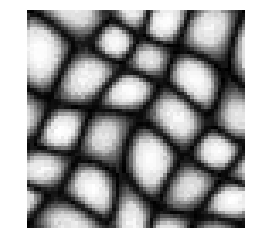

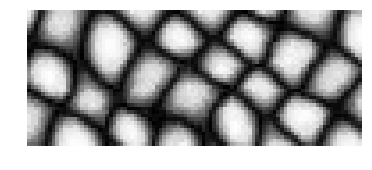

In [38]:
imgYogGray=rgb2gray(np.array(mpimg.imread('../../161.gif')))
plt.imshow(imgYogGray,cmap='gray')
plt.axis('off')
plt.show()
a=OverlapConstraint(imgYogGray,10,3,44,100)
plt.imshow(a,cmap='gray')
plt.axis('off')
plt.savefig('Yog.png',bbox_inches='tight',dpi=300)